In [2012]:
import requests
import zipfile
import os

In [2047]:
# This process of downloading the images might take up to a minute

url = "https://www.kaggle.com/api/v1/datasets/download/abhranta/brain-tumor-detection-mri"

# Get the current directory
current_directory = os.getcwd()

# Define the output file path and extraction folder
output_file = os.path.join(current_directory, "brain-tumor-mri-dataset.zip")
extract_to = os.path.join(current_directory, "brain-tumor-mri-dataset")

# Check if the folder exists and has images
def folder_has_images(folder_path):
    if not os.path.exists(folder_path):
        return False
    for root, _, files in os.walk(folder_path):
        if any(file.lower().endswith(('.png', '.jpg', '.jpeg')) for file in files):
            return True
    return False

# Only proceed if the folder does not exist or has no images
if not folder_has_images(extract_to):
    print("Downloading and extracting dataset...")

    # Step 1: Download the file
    response = requests.get(url, allow_redirects=True)
    with open(output_file, "wb") as file:
        file.write(response.content)

    # Step 2: Unzip the file
    if zipfile.is_zipfile(output_file):
        with zipfile.ZipFile(output_file, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"File unzipped to {extract_to}")

        os.remove(output_file)
        print(f"Deleted the ZIP file: {output_file}")
    else:
        print("The downloaded file is not a valid zip file.")
else:
    print(f"The dataset folder already exists and contains images: {extract_to}")


The dataset folder already exists and contains images: /Users/nestorxx-xx/Library/Mobile Documents/com~apple~CloudDocs/CODE/Visual Studio/MRI_Tumor_Detection/Deep_Learning_Model/brain-tumor-mri-dataset


In [2014]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import glob

In [2015]:
# Define the root directory of your new dataset
ROOT_DIR = os.path.join(current_directory, "brain-tumor-mri-dataset", "Brain_Tumor_Detection")

# Dictionary to hold the number of images for each class
number_of_images = {}

# We'll only count the 'yes' and 'no' folders
classes_to_count = ["yes", "no"]

# Loop through the directories in the root
for dir_name in os.listdir(ROOT_DIR):
    dir_path = os.path.join(ROOT_DIR, dir_name)
    
    # Only process if it's one of the classes_to_count
    if dir_name in classes_to_count and os.path.isdir(dir_path):
        # Count how many images are in this directory
        number_of_images[dir_name] = len([
            f for f in os.listdir(dir_path)
            if os.path.isfile(os.path.join(dir_path, f))
        ])

# Print the results
for class_name, count in number_of_images.items():
    print(f"Class '{class_name}' contains {count} images.")



Class 'no' contains 326 images.
Class 'yes' contains 326 images.


### Dataset Splitting Strategy

The dataset will be divided into three parts:

1. **Training Data (70%)**: Used to train the model and learn patterns.
2. **Validation Data (15%)**: Used during training for hyperparameter tuning and performance checks.
3. **Test Data (15%)**: Used for evaluating the final model on unseen data.

### Summary

| Split         | Percentage | Purpose                              |
|---------------|------------|--------------------------------------|
| **Training**  | 70%        | Learn patterns and train the model. |
| **Validation**| 15%        | Tune hyperparameters and avoid overfitting. |
| **Testing**   | 15%        | Evaluate the model on unseen data.  |

### Directory Structure
```
split_dataset/
├── train/
│   ├── Tumor/
│   └── Normal/
├── val/
│   ├── Tumor/
│   └── Normal/
├── test/
│   ├── Tumor/
│   └── Normal/
```


In [2016]:
Training_Data_Percent = 0.7
Validation_Data_Percent = 0.15
Testing_Data_Percent = 0.15

In [2017]:
def dataFolder(p, split):
    """
    p: Name of the split folder (e.g., "train", "val", "test").
    split: Fraction of images to copy from each class folder (0 < split <= 1).
    """
    # Target directory, e.g. "split_dataset/train"
    target_dir = os.path.join("split_dataset", p)  

    # 1) Create target_dir if it doesn't already exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

        # 2) Create folders for "yes" and "no" within target_dir
        yes_dir = os.path.join(target_dir, "yes")
        no_dir = os.path.join(target_dir, "no")
        os.makedirs(yes_dir, exist_ok=True)
        os.makedirs(no_dir, exist_ok=True)

        # 3) Loop over subdirectories (yes, no, pred) in ROOT_DIR
        for dir_name in os.listdir(ROOT_DIR):
            dir_path = os.path.join(ROOT_DIR, dir_name)

            # We only want to process the yes/no directories, skipping pred
            if os.path.isdir(dir_path):
                if dir_name == "yes":
                    # Gather all images in the "yes" folder
                    images = os.listdir(dir_path)
                    # Number of images to move
                    num_images = min(len(images), math.floor(split * len(images)))
                    # Randomly pick which images to move
                    selected_images = np.random.choice(images, size=num_images, replace=False)

                    # Copy then remove them from the original folder
                    for img in selected_images:
                        src = os.path.join(dir_path, img)
                        dst = os.path.join(yes_dir, img)
                        shutil.copy(src, dst)
                        os.remove(src)

                elif dir_name == "no":
                    # Gather all images in the "no" folder
                    images = os.listdir(dir_path)
                    num_images = min(len(images), math.floor(split * len(images)))
                    selected_images = np.random.choice(images, size=num_images, replace=False)

                    for img in selected_images:
                        src = os.path.join(dir_path, img)
                        dst = os.path.join(no_dir, img)
                        shutil.copy(src, dst)
                        os.remove(src)

        print(f"Dataset split into '{p}' folder successfully.")

    else:
        print(f"The '{p}' folder already exists. No changes made.")

In [2018]:
dataFolder("train",Training_Data_Percent)

The 'train' folder already exists. No changes made.


In [2019]:
dataFolder("val",Validation_Data_Percent)

The 'val' folder already exists. No changes made.


In [2020]:
dataFolder("test",Testing_Data_Percent)

The 'test' folder already exists. No changes made.


### Model Build

In [2021]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

In [2022]:
#CNN Model

model = Sequential()

# Layers
model.add(Conv2D(filters=16, kernel_size= (3,3), activation="relu", input_shape = (224,224,3)))

model.add(Conv2D(filters=36, kernel_size= (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2))) #Prevent overfitting

model.add(Conv2D(filters=64, kernel_size= (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2))) #Prevent overfitting

model.add(Conv2D(filters=128, kernel_size= (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2))) #Prevent overfitting

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation="relu"))  
model.add(Dropout(rate=0.25))  # Dropout to prevent overfitting
model.add(Dense(units=1, activation="sigmoid"))  


model.summary()



Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_250 (Conv2D)             │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_251 (Conv2D)             │ (None, 220, 220, 36)   │         5,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_187               │ (None, 110, 110, 36)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_252 (Conv2D)             │ (None, 108, 108, 64)   │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_188               │ (None, 54, 54, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_253 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_189               │ (None, 26, 26, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_116 (Flatten)           │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,638,245 (21.51 MB)

 Trainable params: 5,638,245 (21.51 MB)

 Non-trainable params: 0 (0.00 B)

In [2023]:
# Compile

model.compile(optimizer="adam", loss= keras.losses.binary_crossentropy, metrics=["accuracy"])

### Preparing our data using data generator

In [2024]:

from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2025]:
def preprocessingImages(path, type):
    """
    Input: Path
    Output: Preprocessed images using ImageDataGenerator
    """
    if type == "train":
        image_data = ImageDataGenerator(
            zoom_range=0.2,
            shear_range=0.2,
            preprocessing_function= preprocess_input,
            horizontal_flip=True,
        )
    else:
        # Only preprocess validation/testing data
        image_data = ImageDataGenerator(
            preprocessing_function= preprocess_input
        )
    
    # Ensure images are resized to 224x224
    image = image_data.flow_from_directory(
        directory=path,
        target_size=(224, 224),  # Matches model input size
        batch_size=32,
        class_mode="binary"  # Must match the type of classification
    )
    
    return image


In [2026]:
train_data = preprocessingImages("split_dataset/train", "train")

Found 2099 images belonging to 2 classes.


In [2027]:
train_data.class_indices

{'no': 0, 'yes': 1}

In [2028]:
test_data = preprocessingImages("split_dataset/test", "test")

Found 114 images belonging to 2 classes.


In [2029]:
val_data = preprocessingImages("split_dataset/val", "val")

Found 134 images belonging to 2 classes.


In [2030]:
# Ensures the folder "models/placeholder" is created only once.
import os

models_folder = "models/placeholder"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

In [2031]:
# Call Back

from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, mode= "auto")

mc = ModelCheckpoint(monitor="val_accuracy",filepath=os.path.join(models_folder, "bestmodel.keras"), verbose=1, save_best_only=True, mode="auto")

cb = [es,mc]

### Model Trainig 

In [2032]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input

In [2033]:
base_model = MobileNet(input_shape= (224,224,3), include_top=False)

In [2034]:
for layer in base_model.layers:
    layer.trainable = False

In [2035]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation="sigmoid")(X)

model = Model(base_model.input, X)

In [2036]:
model.compile(optimizer="rmsprop", 
            loss=keras.losses.binary_crossentropy, 
            metrics=["accuracy"])

In [2037]:
hist = model.fit(
        train_data, 
        steps_per_epoch=8, 
        epochs=30, 
        validation_data=val_data, 
        validation_steps=16, 
        callbacks=cb
    )

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.4197 - loss: 14.3571
Epoch 1: val_accuracy improved from -inf to 0.64179, saving model to models/placeholder/bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step - accuracy: 0.4348 - loss: 13.9256 - val_accuracy: 0.6418 - val_loss: 3.1127
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6379 - loss: 2.9926
Epoch 2: val_accuracy improved from 0.64179 to 0.91045, saving model to models/placeholder/bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.6482 - loss: 2.9022 - val_accuracy: 0.9104 - val_loss: 0.6493
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9288 - loss: 0.3599
Epoch 3: val_accuracy did not improve from 0.91045
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.9302 - loss: 0.3529 - val_accuracy: 0.9030 - val_loss: 0.7472
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7083 - loss: 3.3281
Epoch 4: val_accuracy improved from 0.91045 to 0.93284,

In [2038]:
# Load the best fit model

model = load_model(os.path.join(models_folder, "bestmodel.keras"))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)
accuracy_percent = round(accuracy * 100, 2)
loss = round(loss, 4)
print(f"Our model accuracy is {accuracy_percent} %")
print(f"Our model loss is {loss}")  

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9707 - loss: 0.1522
Our model accuracy is 97.37 %
Our model loss is 0.1854


In [2039]:
h = hist.history

h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Save all the model information

In [2040]:
subfolder_name = f"model-{accuracy_percent:.2f}-{loss:.4f}"
models_folder = "models"
model_sub_path = os.path.join(models_folder, subfolder_name)

if not os.path.exists(model_sub_path):
    os.makedirs(model_sub_path)

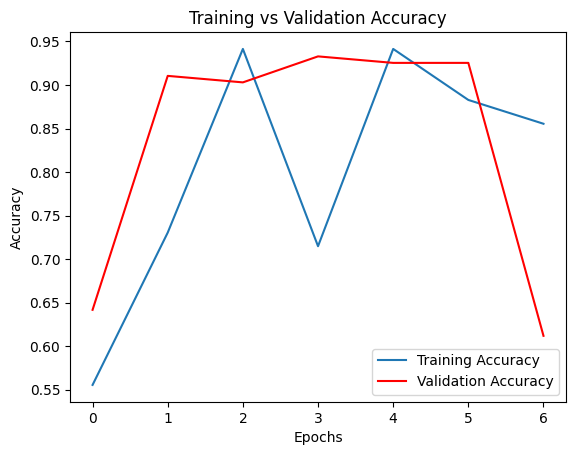

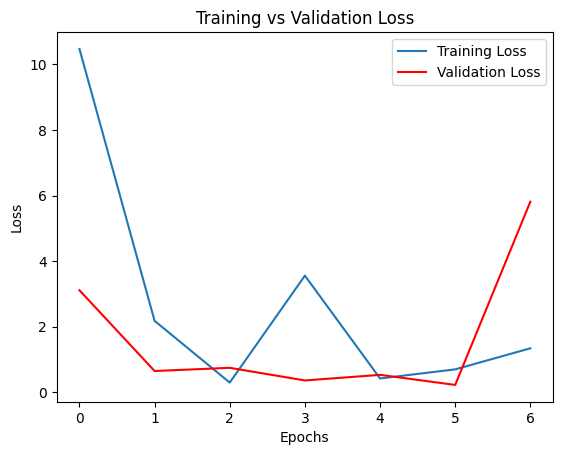

In [ ]:
import datetime

# (A) Save the model
model_path = os.path.join(model_sub_path, "bestmodel.keras")
model.save(model_path)

# (B) Write metadata (accuracy, loss, date, etc.) to a text file
metadata_file = os.path.join(model_sub_path, "model_info.txt")
with open(metadata_file, "w") as f:
    f.write("Model Information\n")
    f.write("=================\n")
    f.write(f"Saved on: {datetime.datetime.now()}\n")
    f.write(f"Test Accuracy: {accuracy_percent:.2f}%\n")
    f.write(f"Test Loss: {loss:.4f}\n")
    f.write("\nAdditional notes here...\n\n")

# (C) Save your charts (accuracy/loss plots)
import matplotlib.pyplot as plt

# Suppose you have 'hist.history'
h = hist.history

# Accuracy chart
plt.plot(h["accuracy"], label="Training Accuracy")
plt.plot(h["val_accuracy"], label="Validation Accuracy", color="red")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

accuracy_chart_path = os.path.join(model_sub_path, "accuracy_chart.png")
plt.savefig(accuracy_chart_path)
plt.show()
plt.close()  # close so it doesn't show in some environments

# Loss chart
plt.plot(h["loss"], label="Training Loss")
plt.plot(h["val_loss"], label="Validation Loss", color="red")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

loss_chart_path = os.path.join(model_sub_path, "loss_chart.png")
plt.savefig(loss_chart_path)
plt.show()
plt.close()


In [2042]:
def get_prediction(path):
    img = image.load_img(path, target_size=(224, 224))

    input_arr = img_to_array(img)
    input_arr = np.expand_dims(input_arr, axis=0)
    input_arr = input_arr / 255.0

    # Predict with the model
    prob = model.predict(input_arr)[0][0]  # extract scalar float
    # If prob >= 0.5 => class 1 (tumor), else class 0 (healthy)
    pred = 1 if prob >= 0.5 else 0
    return pred

def predict_img(path):

    # Predict with the model
    pred = get_prediction(path)

    if pred == 0:
        print("The MRI image is of a HEALTHY BRAIN")
    else:
        print("The MRI image indicates a TUMOR")
        
    # Display the input image
    img = image.load_img(path, target_size=(224, 224))
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Display the first image
    axes[0].imshow(img)
    axes[0].set_title("Original MRI Image")
    axes[0].axis('off')  # Turn off axis

    # Display the second image
    axes[1].imshow(input_arr[0])
    axes[1].set_title("Preprocessed MRI Image")
    axes[1].axis('off')  # Turn off axis

    # Show the images
    plt.tight_layout()
    plt.show()


In [2043]:
import os

def evaluate_folder(folder, type):
    image_paths = [
        os.path.join(folder, f) 
        for f in os.listdir(folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    h = 1
    type_txt = "TUMOR"
    if type == "no":
        type_txt = "HEALTHY"
        h= 0
    total = 0
    correct = 0
    misclassified = []

    for img_path in image_paths:
        pred = get_prediction(img_path)  # 0 or 1

        total += 1
        if pred == h:
            correct += 1
        else:
            misclassified.append(img_path)

    success_percentage = (correct / total) * 100
    print(f"\nTotal images in '{type}' folder: {total}")
    print(f"Correctly predicted as {type_txt}: {correct}")
    print(f"Success percentage: {success_percentage:.2f}%")
    
    with open(metadata_file, "a") as f:
        f.write(f"Check on {type} folder\n")
        f.write(f"  -Total images in '{type}' folder: {total}\n")
        f.write(f"  -Correctly predicted as {type_txt}: {correct}\n")
        f.write(f"  -Success percentage: {success_percentage:.2f}%\n\n")

In [2044]:
# Go through the yes folder and check

yes_folder = "brain-tumor-mri-dataset/Brain_Tumor_Detection/yes"
evaluate_folder(yes_folder, "yes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [2045]:
# Go through the no folder and check

no_folder = "brain-tumor-mri-dataset/Brain_Tumor_Detection/no"
evaluate_folder(no_folder, "no")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [2050]:
from PIL import Image
import os

def images_check(directory):
    for root, _, files in os.walk(directory):
        for name in files:
            path = os.path.join(root, name)
            if not name.lower().endswith(('.jpg', '.jpeg', '.png')):
                print("Non-image file found:", path)
                continue

            try:
                with Image.open(path) as img:
                    img.verify()  # Just verifies if it can open
            except Exception as e:
                print("Corrupted/Unidentified image:", path, e)


In [2055]:
images_check("brain-tumor-mri-dataset")

Corrupted/Unidentified image: brain-tumor-mri-dataset/Brain_Tumor_Detection/no/no332.jpg cannot identify image file '/Users/nestorxx-xx/Library/Mobile Documents/com~apple~CloudDocs/CODE/Visual Studio/MRI_Tumor_Detection/Deep_Learning_Model/brain-tumor-mri-dataset/Brain_Tumor_Detection/no/no332.jpg'
